In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn import linear_model
import pandas as pd

In [2]:
def pinball_loss(data, quant_preds, quantiles):
    loss = 0
    for t in range(len(data)):
        for i in range(len(quantiles)):
            q = quantiles[i]
            quant_pred = quant_preds[t][i]
            if quant_pred > data[t]:
                loss += (quant_pred - data[t]) * (1 - q)
            else:
                loss += (data[t] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [3]:
# meter_id = 56
# finals_df = pd.read_csv(".\\GEFCom2017\\GEFCom2017-Final\\load.csv")
# finals_df = finals_df[finals_df.meter_id==meter_id]

In [4]:
# finals_df

In [5]:
# loads = finals_df.iloc[:, 2:].to_numpy()
# loads = loads.reshape(loads.size)
# dates = finals_df.date.to_numpy().repeat(24)

In [6]:
# temps_df = pd.read_csv(".\\GEFCom2017\\GEFCom2017-Final\\temperature.csv")

In [7]:
# offset = 0
# i = 0
# while i < loads.shape[0]:
#     if i % 24 + 1 != temps_df.hr.iloc[i]:
#         print(i, temps_df.hr.iloc[i])
#         idxs = temps_df.index.to_numpy()
#         idxs[i:] += 1
#         temps_df.index = idxs
#         fake_data = (temps_df.loc[i - 1].iloc[1:] + temps_df.loc[i + 1].iloc[1:]) // 2
#         fake_data = pd.DataFrame(fake_data).transpose()
#         fake_data.index = [i]
#         temps_df = temps_df.append(fake_data, sort=True)
#         temps_df.date[i] = temps_df.date[i + 1]
#         temps_df = temps_df.sort_index()
#         i += 1
#     i += 1

In [3]:
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2005-2015.json", "r") as f:
    alldata = json.loads(f.read())

In [4]:
zone_data = alldata["ISONE CA"]

In [5]:
all_df = pd.DataFrame({"date": zone_data["Date"], "load": zone_data["DEMAND"], "temp": zone_data["DryBulb"]})

In [6]:
all_df.date = pd.to_datetime(all_df.date)
train_start = all_df.index[list(date == pd.Timestamp("2014-10-01") for date in all_df.date)][0]
start_date = all_df.date.iloc[train_start]
train_through = all_df[all_df.date == start_date.replace(year=start_date.year + 1)].index[0]

In [7]:
all_df["day_of_week"] = list((i // 24) % 7 for i in range(len(all_df)))
all_df["hour_end"] = list(i % 24 + 1 for i in range(len(all_df)))
all_df["month"] = list(all_df.date.loc[i].month for i in all_df.index)
all_df["day_of_year"] = list(date.timetuple().tm_yday for date in all_df.date)
all_df["year"] = list(date.timetuple().tm_year for date in all_df.date)

In [8]:
all_df

,date,load,temp,day_of_week,hour_end,month,day_of_year,year
0,2005-01-01,12118.0,44,0,1,1,1,2005
1,2005-01-01,11385.0,44,0,2,1,1,2005
2,2005-01-01,10847.0,43,0,3,1,1,2005
3,2005-01-01,10576.0,41,0,4,1,1,2005
4,2005-01-01,10505.0,42,0,5,1,1,2005
...,...,...,...,...,...,...,...,...
96403,2015-12-31,15048.0,39,5,20,12,365,2015
96404,2015-12-31,14361.0,38,5,21,12,365,2015
96405,2015-12-31,13635.0,38,5,22,12,365,2015
96406,2015-12-31,12900.0,37,5,23,12,365,2015


In [9]:
bad_idxs = all_df.load.isnull().to_numpy().nonzero()[0]
all_df.loc[bad_idxs, "load"] = (all_df.load.values[bad_idxs - 1] + all_df.load.values[bad_idxs + 1]) / 2

In [10]:
all_df.loc[bad_idxs, "load"]

Series([], Name: load, dtype: float64)

In [11]:
variables = pd.DataFrame(all_df.temp)

In [12]:
variables["temp2"] = variables.temp ** 2
variables["temp3"] = variables.temp ** 3
variables["trend"] = variables.index

for i in range(2, 13):
    variables[f"m{i}"] = (i == all_df.month) * 1  # converts to int
    variables[f"tempmonth{i}"] = variables.temp * variables[f"m{i}"]
    variables[f"temp2month{i}"] = variables.temp2 * variables[f"m{i}"]
    variables[f"temp3month{i}"] = variables.temp3 * variables[f"m{i}"]

for i in range(2, 25):
    variables[f"h{i}"] = (i == all_df.hour_end) * 1
    variables[f"temphour{i}"] = variables.temp * variables[f"h{i}"]
    variables[f"temp2hour{i}"] = variables.temp2 * variables[f"h{i}"]
    variables[f"temp3hour{i}"] = variables.temp3 * variables[f"h{i}"]

for i in range(1, 7):
    variables[f"w{i}"] = (i == all_df.day_of_week) * 1
    
for i in range(1, 7):
    for j in range(2, 25):
        variables[f"wh{i}_{j}"] = variables[f"w{i}"] * variables[f"h{j}"]

# Train

In [13]:
cap = train_through
train_df = all_df.iloc[train_start:cap]
train_vars = variables.iloc[train_start:cap]

In [14]:
train_vars.iloc[:50]

,temp,temp2,temp3,trend,m2,tempmonth2,temp2month2,temp3month2,m3,tempmonth3,...,wh6_15,wh6_16,wh6_17,wh6_18,wh6_19,wh6_20,wh6_21,wh6_22,wh6_23,wh6_24
85440,57,3249,185193,85440,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85441,57,3249,185193,85441,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85442,57,3249,185193,85442,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85443,57,3249,185193,85443,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85444,57,3249,185193,85444,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85445,57,3249,185193,85445,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85446,57,3249,185193,85446,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85447,57,3249,185193,85447,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85448,57,3249,185193,85448,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85449,57,3249,185193,85449,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
reg = linear_model.LinearRegression()

reg.fit(train_vars, train_df.load)

LinearRegression()

<IPython.core.display.Javascript object>


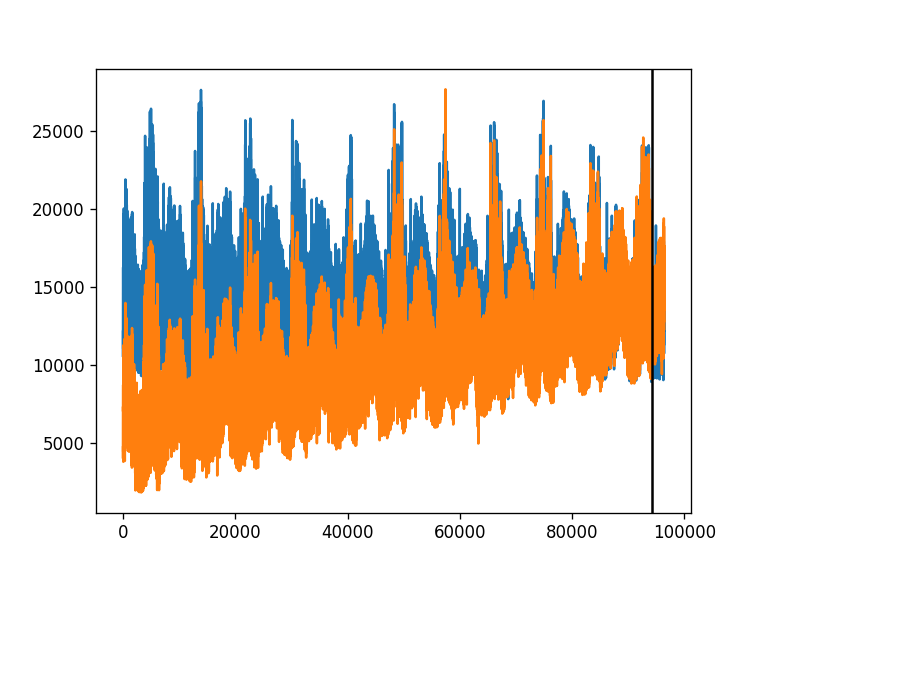

In [28]:
%matplotlib notebook 
fit = reg.predict(variables)
plt.figure()
plt.plot(all_df.load.values)
plt.plot(fit)
plt.axvline(train_through, color="k")
plt.show()

In [30]:
actual_mean = np.mean(train_df.load)
predicted_mean = np.mean(fit[train_start:cap])
print(actual_mean, predicted_mean)
print((actual_mean - predicted_mean) / actual_mean)

14445.420947488585 14370.82314572906
0.005164114083673942


# Test

In [17]:
#  ###---TEST---###
gap = 0 * 24
test_length = 31 * 24
start = train_through + gap
cap = train_through + test_length + gap
test_demand = all_df.load[start:cap]
test_days_of_year = np.unique(all_df.day_of_year.iloc[start:cap].values)

temp_years = [2014]
temps = []
years = np.unique(train_df.year) if temp_years is None else temp_years
num_years = len(years)
k = int((99 / num_years - 1) / 2 + 0.5)
print("k =", k)
for yr in years:
    this_year = all_df.iloc[:train_through][all_df.year.iloc[:train_through] == yr]
    for shift in range(-k, k + 1):
        include = list(day + shift in test_days_of_year for day in this_year.day_of_year)
        temps.append(this_year.temp[include].values)

k = 49


In [18]:
np.mean(temps)

52.93589116976214

In [19]:
np.array(temps).shape

(99, 744)

In [20]:
diff = np.mean(temps, axis=0) - variables.temp[start:cap].values

<IPython.core.display.Javascript object>


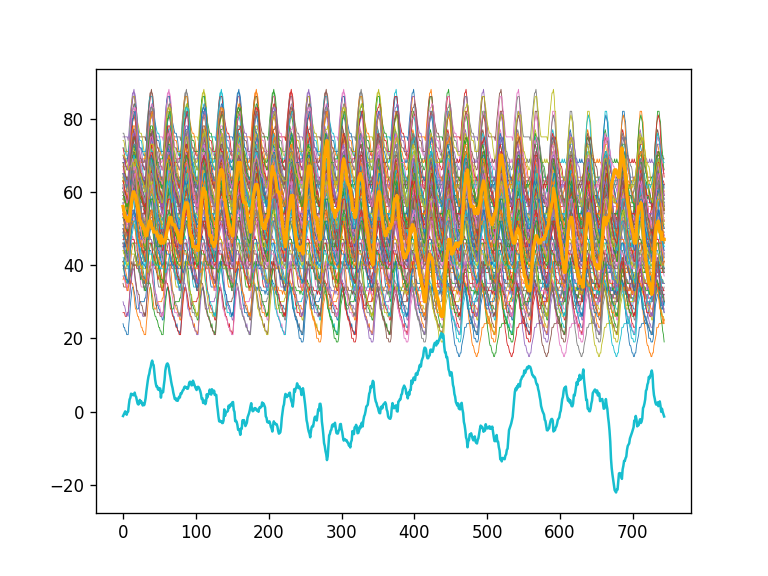

In [21]:
%matplotlib notebook
plt.plot(np.array(temps).T, linewidth=0.5)
plt.plot(variables.temp[start:cap].values, linewidth=2, color="orange")
plt.plot(diff)
plt.show()

In [22]:
preds = []
for i, temp in enumerate(temps):
    test_vars = variables.iloc[start:cap].copy()
    
    test_vars.loc[:, "temp"] = temp
    test_vars.loc[:, "temp2"] = temp ** 2
    test_vars.loc[:, "temp3"] = temp ** 3

    for i in range(2, 13):
        test_vars.loc[:, f"tempmonth{i}"] = test_vars.temp * test_vars[f"m{i}"]
        test_vars.loc[:, f"temp2month{i}"] = test_vars.temp2 * test_vars[f"m{i}"]
        test_vars.loc[:, f"temp3month{i}"] = test_vars.temp3 * test_vars[f"m{i}"]

    for i in range(2, 25):
        test_vars.loc[:, f"temphour{i}"] = test_vars.temp * test_vars[f"h{i}"]
        test_vars.loc[:, f"temp2hour{i}"] = test_vars.temp2 * test_vars[f"h{i}"]
        test_vars.loc[:, f"temp3hour{i}"] = test_vars.temp3 * test_vars[f"h{i}"]
        
    preds.append(reg.predict(test_vars))

preds = np.array(preds)

In [23]:
test_vars.columns

Index(['temp', 'temp2', 'temp3', 'trend', 'm2', 'tempmonth2', 'temp2month2',
       'temp3month2', 'm3', 'tempmonth3',
       ...
       'wh6_15', 'wh6_16', 'wh6_17', 'wh6_18', 'wh6_19', 'wh6_20', 'wh6_21',
       'wh6_22', 'wh6_23', 'wh6_24'],
      dtype='object', length=284)

In [175]:
# test_vars.iloc[1000:1050, -100:-80]

<IPython.core.display.Javascript object>


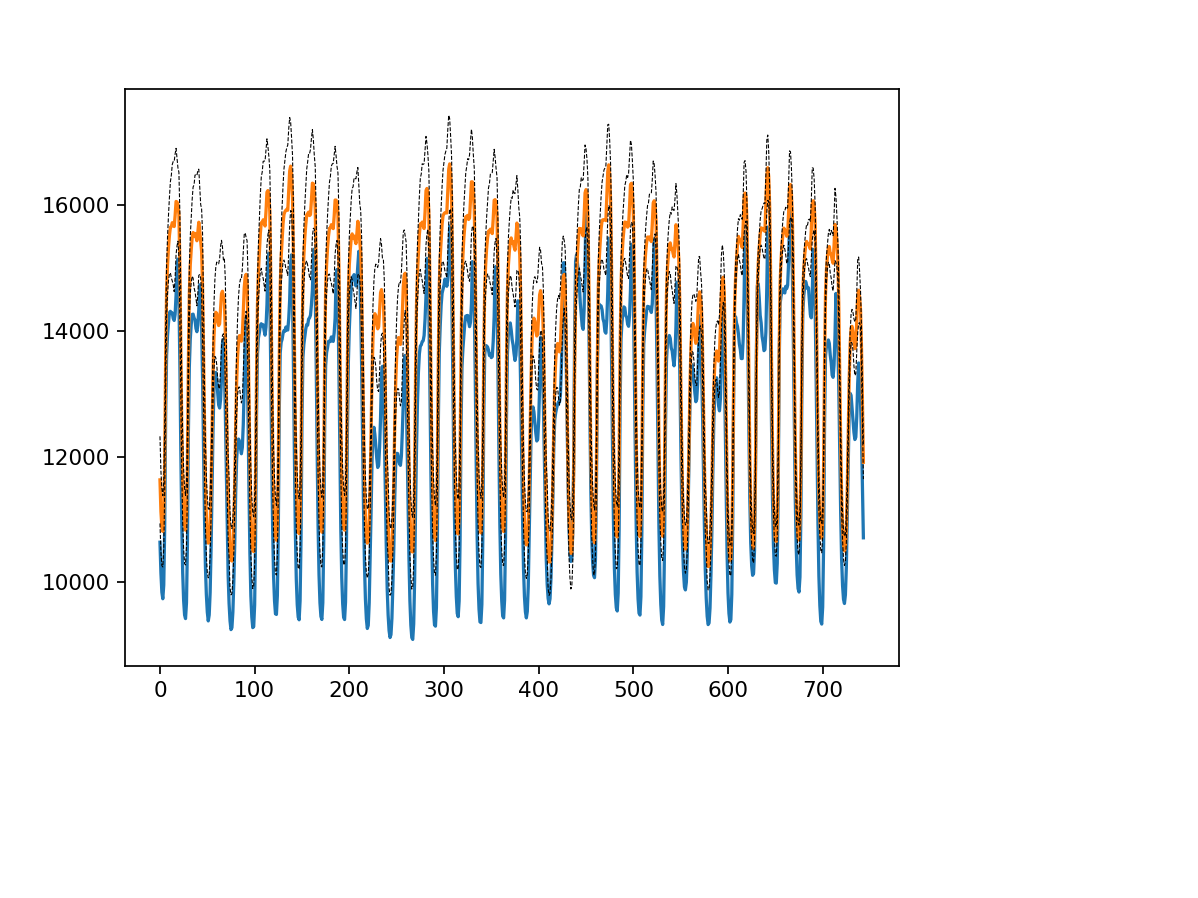

In [24]:
pred = np.mean(preds, axis=0)
std = np.std(preds, axis=0)
plt.figure(dpi=130)
plt.plot(test_demand.values)
plt.plot(pred)
plt.plot(std + pred, linestyle="--", color="black", linewidth=0.5)
plt.plot(pred - std, linestyle="--", color="black", linewidth=0.5)
plt.show()

In [25]:
quant_preds = []
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for t in range(preds.shape[1]):
    sorted_preds = np.sort(preds[:, t])
    quant_pred = []
    for q in quantiles:
        idx = int(q * preds.shape[0] + 0.5)
        quant_pred.append(sorted_preds[idx])
    quant_preds.append(quant_pred)

In [26]:
print(quant_preds[100])

[10463.869573650365, 10489.713131224133, 10509.326535213033, 10578.765782876093, 10662.415931888034, 10725.78094359679, 10793.734589222433, 11007.03848792622, 11236.329725139629]


In [27]:
pinball_loss(test_demand.values, quant_preds, quantiles)

481.72649540917087